Notebook para la pruebas de clasificación de Click_Bait usando otros modelos BERT.

In [65]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from datasets import load_dataset, Dataset
from transformers import (
    Trainer,
    TrainingArguments
)
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report
)

In [66]:
os.environ.pop("TRANSFORMERS_OFFLINE", None)
os.environ.pop("HF_HUB_OFFLINE", None)

Se hacen configuraciones basicas para una primera prueba, y se muestra si el entorno es capaz de ejecutarse en CUDA o con el CPU

In [67]:
MODEL_NAME = "dccuchile/bert-base-spanish-wwm-cased"
NUM_LABELS = 2          # 0 = no clickbait, 1 = clickbait
MAX_LENGTH = 128
BATCH_SIZE = 8
EPOCHS = 5

ejemplo = "sanidad revende 30.000 dosis de la vacuna contra el coronavirus a Andorra"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

Usando dispositivo: cuda


Carga de los csv ya Pre divididos, 75 - 25, y codificación del target

In [68]:
data_files = {
    "train": "TA1C_dataset_detection_train_split.csv",
    "test": "TA1C_dataset_detection_dev_split.csv",
}

dataset = load_dataset("csv", data_files=data_files)
dataset = dataset.class_encode_column("Tag Value")
dataset = dataset.rename_column("Tag Value", "labels")

print("Ejemplo de fila:", dataset["train"][1])

Ejemplo de fila: {'Teaser Text': 'sanidad revende 30.000 dosis de la vacuna contra el coronavirus a andorra', 'labels': 1}


Se realiza la selección del modelo y tokenización de los features

In [69]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)

print(tokenizer.__class__.__name__)
print(model.__class__.__name__)

def tokenize_function(examples):
    return tokenizer(
        examples["Teaser Text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH
    )

encoded_dataset = dataset.map(tokenize_function, batched=True)

encoded_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"]
)

train_dataset = encoded_dataset["train"]
eval_dataset  = encoded_dataset["test"]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertTokenizerFast
BertForSequenceClassification


Map: 100%|██████████| 700/700 [00:00<00:00, 19395.24 examples/s]


Ejemplo de tokenización

In [70]:
tokens = tokenizer.tokenize(ejemplo)
print("Tokens:\n", tokens)

encoding = tokenizer(
    ejemplo,
    truncation=True,
    padding="max_length",
    max_length=128,
)

print("\n", encoding.keys())
print("\n", encoding["input_ids"][:20])
print("\n", encoding["attention_mask"][:20])

decodificado = tokenizer.decode(encoding["input_ids"], skip_special_tokens=True)
print("\nMensaje decodificado:\n", decodificado)

Tokens:
 ['sanidad', 'rev', '##ende', '30', '.', '000', 'dosis', 'de', 'la', 'vacuna', 'contra', 'el', 'corona', '##vir', '##us', 'a', 'Andorra']

 KeysView({'input_ids': [4, 17986, 4511, 23281, 2101, 1009, 2273, 6781, 1008, 1030, 19175, 1534, 1040, 12078, 2388, 1212, 1013, 23911, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Definición de metricas

In [71]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc         = accuracy_score(labels, preds)
    f1_macro    = f1_score(labels, preds, average="macro")
    f1_weighted = f1_score(labels, preds, average="weighted")
    prec_macro  = precision_score(labels, preds, average="macro", zero_division=0)
    rec_macro   = recall_score(labels, preds, average="macro", zero_division=0)

    return {
        "accuracy": acc,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "precision_macro": prec_macro,
        "recall_macro": rec_macro,
    }

Argumentos de entrenamiento

In [72]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    learning_rate=2e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    seed=0,
    data_seed=0,
    logging_steps=50,
    logging_dir="./logs",
    report_to="none",
)


Definición del entrenador

In [73]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

Ejecución

In [74]:
print("Entrenando modelo BERT en español para clickbait")
trainer.train()
print("\nEvaluando en test")
metrics_BETO = trainer.evaluate()
print("\nMétricas de evaluación:", metrics_BETO)

Entrenando modelo BERT en español para clickbait


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Precision Macro,Recall Macro
1,0.366300,0.422553,0.864286,0.830371,0.862877,0.837743,0.824000
2,0.210400,0.469967,0.862857,0.837176,0.864889,0.828414,0.848500
3,0.066500,0.721472,0.864286,0.838654,0.866215,0.830156,0.849500
4,0.044400,0.807679,0.860000,0.826927,0.859352,0.830060,0.824000
5,0.014700,0.804149,0.871429,0.839041,0.869985,0.847266,0.832000



Evaluando en test



Métricas de evaluación: {'eval_loss': 0.8041490912437439, 'eval_accuracy': 0.8714285714285714, 'eval_f1_macro': 0.8390409908943188, 'eval_f1_weighted': 0.8699845391754518, 'eval_precision_macro': 0.8472658047780428, 'eval_recall_macro': 0.8320000000000001, 'eval_runtime': 1.2611, 'eval_samples_per_second': 555.072, 'eval_steps_per_second': 69.78, 'epoch': 5.0}


Predicciones, Matriz y Reporte

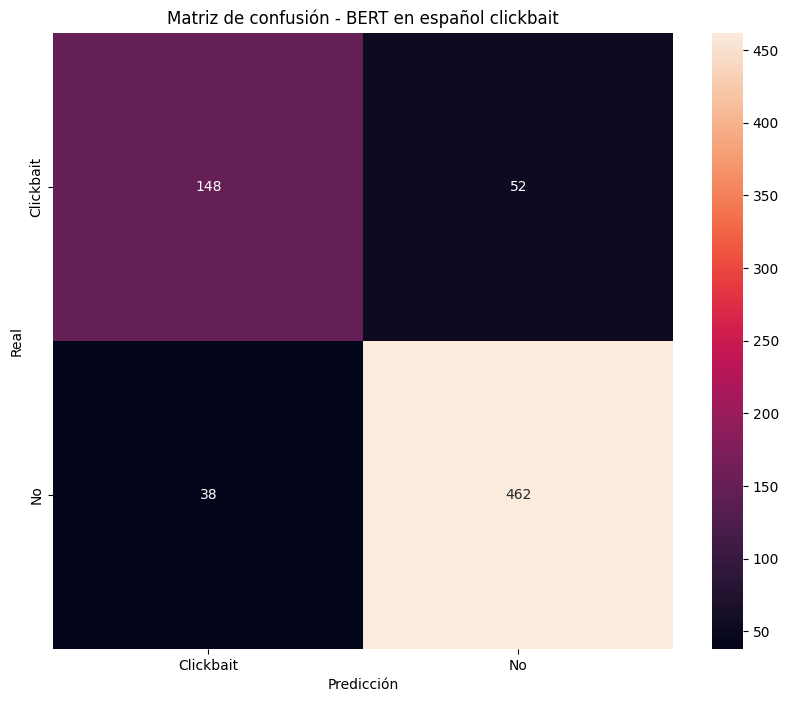


Reporte de clasificación BERT en español:
              precision    recall  f1-score   support

   Clickbait       0.80      0.74      0.77       200
          No       0.90      0.92      0.91       500

    accuracy                           0.87       700
   macro avg       0.85      0.83      0.84       700
weighted avg       0.87      0.87      0.87       700



In [75]:
predictions = trainer.predict(eval_dataset)

y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=-1)

label_names = dataset["train"].features["labels"].names

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,        # muestra los números
    fmt="d",           # enteros
    xticklabels=label_names,
    yticklabels=label_names
)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión - BERT en español clickbait")
plt.show()

print("\nReporte de clasificación BERT en español:")
class_BETO = classification_report(y_true, y_pred, target_names=label_names)
print(class_BETO)

# Otros Modelos

## DistilBETO

Tokenización

In [76]:
MODEL_NAME = "dccuchile/distilbert-base-spanish-uncased"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

encoded_dataset = dataset.map(tokenize_function, batched=True)

encoded_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"]
)

train_dataset = encoded_dataset["train"]
eval_dataset  = encoded_dataset["test"]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/distilbert-base-spanish-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 700/700 [00:00<00:00, 24685.45 examples/s]


Ejemplo de tokenización

In [77]:
tokens = tokenizer.tokenize(ejemplo)
print("Tokens:\n", tokens)

encoding = tokenizer(
    ejemplo,
    truncation=True,
    padding="max_length",
    max_length=128,
)

print("\n", encoding.keys())
print("\n", encoding["input_ids"][:20])
print("\n", encoding["attention_mask"][:20])

decodificado = tokenizer.decode(encoding["input_ids"], skip_special_tokens=True)
print("\nMensaje decodificado:\n", decodificado)

Tokens:
 ['sanidad', 'reven', '##de', '30', '.', '000', 'dosis', 'de', 'la', 'vacuna', 'contra', 'el', 'corona', '##vir', '##us', 'a', 'andorra']

 KeysView({'input_ids': [4, 14609, 28986, 1114, 2286, 1008, 2371, 9934, 1009, 1032, 18742, 1532, 1039, 8132, 10791, 1108, 1012, 22742, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Nuevo modelo

In [78]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

Entrenamiento

In [79]:
print("Entrenando modelo DistilBETO para clickbait")
trainer.train()
print("\nEvaluando en test")
metrics_destil = trainer.evaluate()
print("\nMétricas de evaluación:", metrics_destil)

Entrenando modelo DistilBETO para clickbait


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Precision Macro,Recall Macro
1,0.378700,0.389377,0.837143,0.792038,0.833546,0.807023,0.781000
2,0.223800,0.471748,0.855714,0.821903,0.855160,0.824448,0.819500
3,0.108400,0.651309,0.855714,0.822984,0.855606,0.823474,0.822500
4,0.095700,0.704336,0.858571,0.821502,0.856364,0.832663,0.812500
5,0.037800,0.721420,0.854286,0.817580,0.852649,0.825300,0.811000



Evaluando en test



Métricas de evaluación: {'eval_loss': 0.6513094902038574, 'eval_accuracy': 0.8557142857142858, 'eval_f1_macro': 0.8229840335103493, 'eval_f1_weighted': 0.8556055473348706, 'eval_precision_macro': 0.823473655703668, 'eval_recall_macro': 0.8225, 'eval_runtime': 1.4894, 'eval_samples_per_second': 469.989, 'eval_steps_per_second': 59.084, 'epoch': 5.0}


Metricas de rendimiento

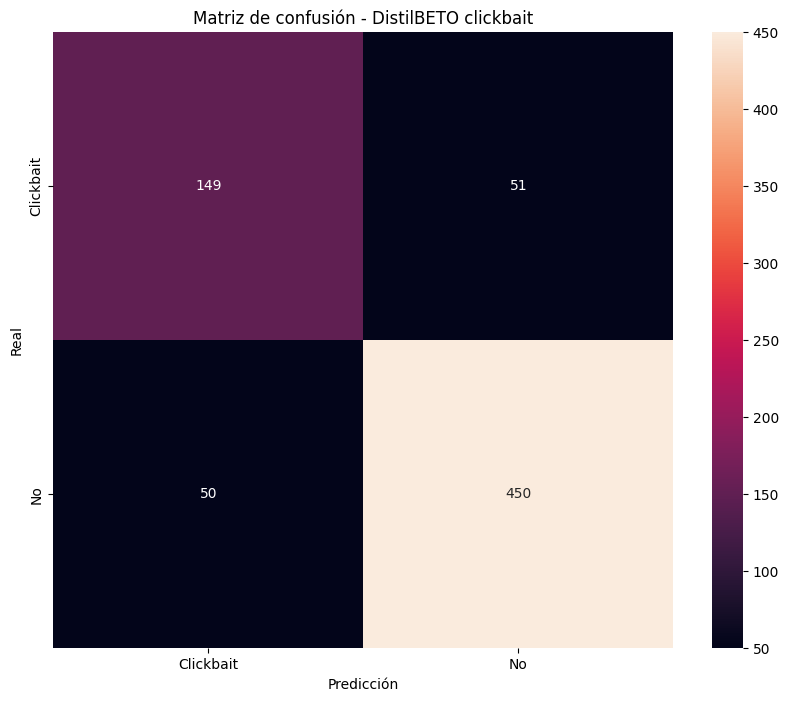


Reporte de clasificación DestilBETO en español:
              precision    recall  f1-score   support

   Clickbait       0.75      0.74      0.75       200
          No       0.90      0.90      0.90       500

    accuracy                           0.86       700
   macro avg       0.82      0.82      0.82       700
weighted avg       0.86      0.86      0.86       700



In [80]:
predictions = trainer.predict(eval_dataset)

y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=-1)

label_names = dataset["train"].features["labels"].names

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=label_names,
    yticklabels=label_names
)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión - DistilBETO clickbait")
plt.show()

print("\nReporte de clasificación DestilBETO en español:")
class_destilBETO = classification_report(y_true, y_pred, target_names=label_names)
print(class_destilBETO)

## RoBERTa Español

Tokenización

In [81]:
MODEL_NAME = "bertin-project/bertin-roberta-base-spanish"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

encoded_dataset = dataset.map(tokenize_function, batched=True)

encoded_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"]
)

train_dataset = encoded_dataset["train"]
eval_dataset  = encoded_dataset["test"]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at bertin-project/bertin-roberta-base-spanish and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 700/700 [00:00<00:00, 23724.97 examples/s]


Ejemplo de tokenización

In [82]:
tokens = tokenizer.tokenize(ejemplo)
print("Tokens:\n", tokens)

encoding = tokenizer(
    ejemplo,
    truncation=True,
    padding="max_length",
    max_length=128,
)

print("\n", encoding.keys())
print("\n", encoding["input_ids"][:20])
print("\n", encoding["attention_mask"][:20])

decodificado = tokenizer.decode(encoding["input_ids"], skip_special_tokens=True)
print("\nMensaje decodificado:\n", decodificado)

Tokens:
 ['san', 'idad', 'Ġrev', 'ende', 'Ġ30', '.', '000', 'Ġdosis', 'Ġde', 'Ġla', 'Ġvacuna', 'Ġcontra', 'Ġel', 'Ġcoronavirus', 'Ġa', 'ĠAndorra']

 KeysView({'input_ids': [0, 4181, 425, 1595, 2517, 2001, 68, 1160, 11398, 313, 332, 21028, 809, 344, 40954, 320, 18211, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Trainer con el modelo actual

In [83]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

Entrenamiento

In [84]:
print("Entrenando modelo RoBERTa en español para clickbait")
trainer.train()
print("\nEvaluando en test")
metrics_RoBERTa = trainer.evaluate()
print("\nMétricas de evaluación:", metrics_RoBERTa)

Entrenando modelo RoBERTa en español para clickbait


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Precision Macro,Recall Macro
1,0.396100,0.424361,0.852857,0.817246,0.851820,0.821954,0.813000
2,0.330100,0.572702,0.867143,0.842051,0.869031,0.833462,0.853000
3,0.163800,0.567654,0.880000,0.850724,0.879056,0.856553,0.845500
4,0.052300,0.685393,0.888571,0.857710,0.886110,0.875858,0.844000
5,0.005900,0.749024,0.881429,0.848331,0.878696,0.866893,0.834500



Evaluando en test



Métricas de evaluación: {'eval_loss': 0.6853930950164795, 'eval_accuracy': 0.8885714285714286, 'eval_f1_macro': 0.8577102292272571, 'eval_f1_weighted': 0.8861101059243475, 'eval_precision_macro': 0.8758576985271622, 'eval_recall_macro': 0.844, 'eval_runtime': 1.2216, 'eval_samples_per_second': 573.027, 'eval_steps_per_second': 72.038, 'epoch': 5.0}


Metricas

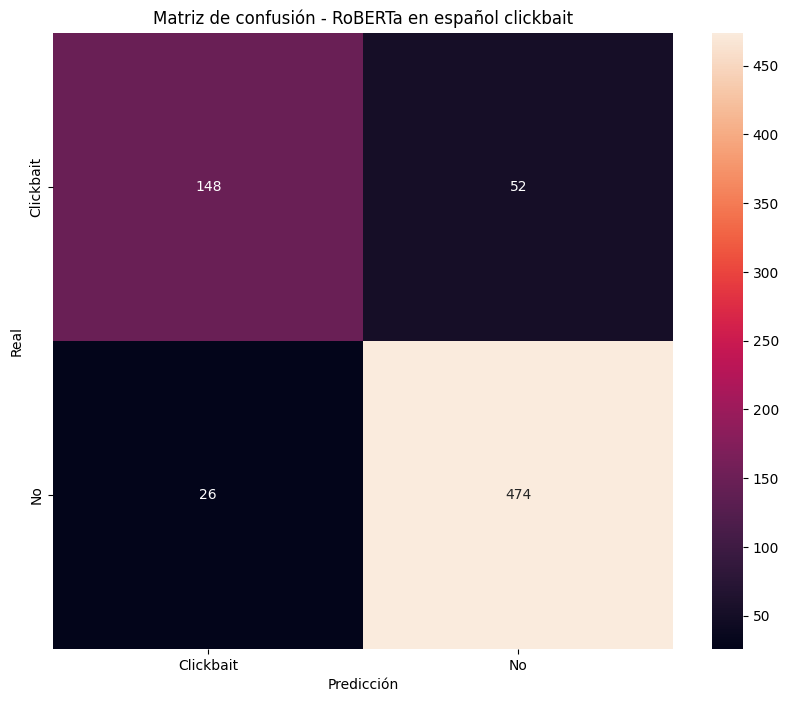


Reporte de clasificación RoBERTa en español:
              precision    recall  f1-score   support

   Clickbait       0.85      0.74      0.79       200
          No       0.90      0.95      0.92       500

    accuracy                           0.89       700
   macro avg       0.88      0.84      0.86       700
weighted avg       0.89      0.89      0.89       700



In [85]:
predictions = trainer.predict(eval_dataset)

y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=-1)

label_names = dataset["train"].features["labels"].names

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=label_names,
    yticklabels=label_names
)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión - RoBERTa en español clickbait")
plt.show()

print("\nReporte de clasificación RoBERTa en español:")
class_RoBERTa = classification_report(y_true, y_pred, target_names=label_names)
print(class_RoBERTa)

## XLM-R base (RoBERTa multilingüe entrenado en un montón de idiomas)

Modelo y Tokenización

In [86]:
MODEL_NAME = "xlm-roberta-base"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

encoded_dataset = dataset.map(tokenize_function, batched=True)

encoded_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"]
)

train_dataset = encoded_dataset["train"]
eval_dataset  = encoded_dataset["test"]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 700/700 [00:00<00:00, 22455.51 examples/s]


Ejemplo de tokenización

In [87]:
tokens = tokenizer.tokenize(ejemplo)
print("Tokens:\n", tokens)

encoding = tokenizer(
    ejemplo,
    truncation=True,
    padding="max_length",
    max_length=128,
)

print("\n", encoding.keys())
print("\n", encoding["input_ids"][:20])
print("\n", encoding["attention_mask"][:20])

decodificado = tokenizer.decode(encoding["input_ids"], skip_special_tokens=True)
print("\nMensaje decodificado:\n", decodificado)

Tokens:
 ['▁san', 'idad', '▁revend', 'e', '▁30.000', '▁dosis', '▁de', '▁la', '▁vacuna', '▁contra', '▁el', '▁corona', 'virus', '▁a', '▁', 'Andorra']

 KeysView({'input_ids': [0, 3725, 3812, 191527, 13, 95829, 101424, 8, 21, 235903, 2304, 88, 109728, 76912, 10, 6, 124180, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Trainer con el modelo actual

In [88]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

Entrenamiento

In [89]:
print("Entrenando modelo XLM-R base para clickbait")
trainer.train()
print("\nEvaluando en test")
metrics_XLM = trainer.evaluate()
print("\nMétricas de evaluación:", metrics_XLM)

Entrenando modelo XLM-R base para clickbait


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Precision Macro,Recall Macro
1,0.372600,0.418780,0.868571,0.837018,0.867752,0.841412,0.833000
2,0.367200,0.455280,0.858571,0.834492,0.861548,0.823037,0.851500
3,0.271900,0.607625,0.875714,0.847521,0.875621,0.848048,0.847000
4,0.197900,0.627045,0.871429,0.836921,0.869071,0.850855,0.826000
5,0.135000,0.642493,0.880000,0.850724,0.879056,0.856553,0.845500



Evaluando en test



Métricas de evaluación: {'eval_loss': 0.642492949962616, 'eval_accuracy': 0.88, 'eval_f1_macro': 0.8507235338918507, 'eval_f1_weighted': 0.8790555978674791, 'eval_precision_macro': 0.8565531475748194, 'eval_recall_macro': 0.8455, 'eval_runtime': 2.0484, 'eval_samples_per_second': 341.736, 'eval_steps_per_second': 42.961, 'epoch': 5.0}


Metricas

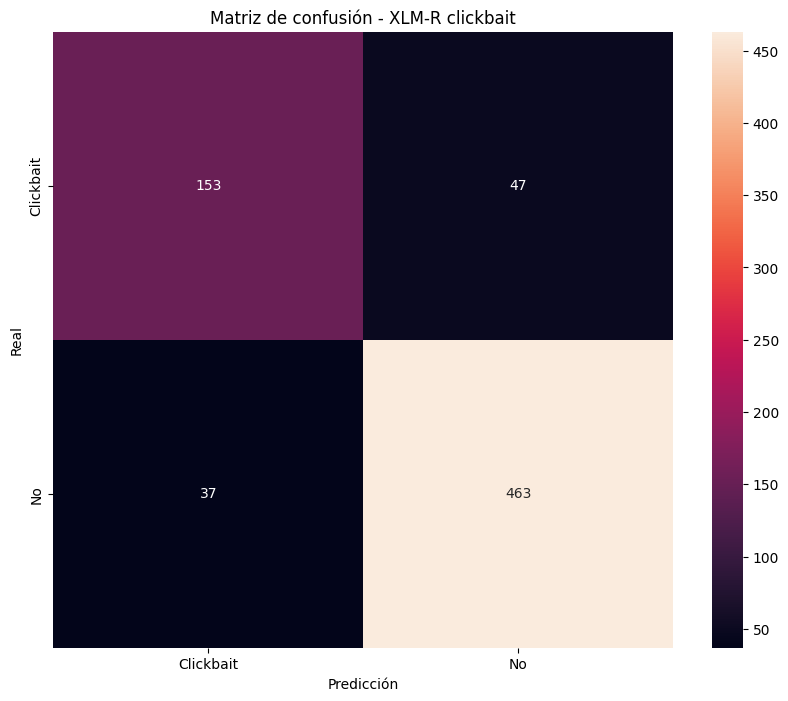


Reporte de clasificación XLM-R:
              precision    recall  f1-score   support

   Clickbait       0.81      0.77      0.78       200
          No       0.91      0.93      0.92       500

    accuracy                           0.88       700
   macro avg       0.86      0.85      0.85       700
weighted avg       0.88      0.88      0.88       700



In [90]:
predictions = trainer.predict(eval_dataset)

y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=-1)

label_names = dataset["train"].features["labels"].names

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=label_names,
    yticklabels=label_names
)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión - XLM-R clickbait")
plt.show()

print("\nReporte de clasificación XLM-R:")
class_XLM = classification_report(y_true, y_pred, target_names=label_names)
print(class_XLM)

## DistilBERT m-cased (DistilBERT miltilenguaje)

Modelo y Tokenización

In [91]:
MODEL_NAME = "distilbert/distilbert-base-multilingual-cased"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

encoded_dataset = dataset.map(tokenize_function, batched=True)

encoded_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"]
)

train_dataset = encoded_dataset["train"]
eval_dataset  = encoded_dataset["test"]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 700/700 [00:00<00:00, 20878.91 examples/s]


Ejemplo de tokenización

In [92]:
tokens = tokenizer.tokenize(ejemplo)
print("Tokens:\n", tokens)

encoding = tokenizer(
    ejemplo,
    truncation=True,
    padding="max_length",
    max_length=128,
)

print("\n", encoding.keys())
print("\n", encoding["input_ids"][:20])
print("\n", encoding["attention_mask"][:20])

decodificado = tokenizer.decode(encoding["input_ids"], skip_special_tokens=True)
print("\nMensaje decodificado:\n", decodificado)

Tokens:
 ['san', '##idad', 'rev', '##ende', '30', '.', '000', 'dos', '##is', 'de', 'la', 'va', '##cun', '##a', 'contra', 'el', 'corona', '##vir', '##us', 'a', 'Andorra']

 KeysView({'input_ids': [101, 14608, 13811, 86095, 13201, 10244, 119, 10259, 10398, 10291, 10104, 10109, 10321, 48917, 10113, 11473, 10125, 31206, 37715, 10251, 169, 42980, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Trainer con el modelo actual

In [93]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

Entrenamiento

In [94]:
print("Entrenando modelo DistilBERT m-cased para clickbait")
trainer.train()
print("\nEvaluando en test")
metrics_DistilBERT = trainer.evaluate()
print("\nMétricas de evaluación:", metrics_DistilBERT)

Entrenando modelo DistilBERT m-cased para clickbait


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Precision Macro,Recall Macro
1,0.406000,0.474391,0.830000,0.784732,0.827039,0.795950,0.776000
2,0.267200,0.496389,0.838571,0.805402,0.839834,0.800933,0.810500
3,0.177000,0.614138,0.844286,0.805373,0.842670,0.812204,0.799500
4,0.116000,0.718515,0.847143,0.810149,0.846065,0.814753,0.806000
5,0.099500,0.738061,0.851429,0.815182,0.850259,0.820433,0.810500



Evaluando en test



Métricas de evaluación: {'eval_loss': 0.7380610108375549, 'eval_accuracy': 0.8514285714285714, 'eval_f1_macro': 0.8151815181518152, 'eval_f1_weighted': 0.8502593116454503, 'eval_precision_macro': 0.8204334365325077, 'eval_recall_macro': 0.8105, 'eval_runtime': 0.6721, 'eval_samples_per_second': 1041.457, 'eval_steps_per_second': 130.926, 'epoch': 5.0}


Metricas

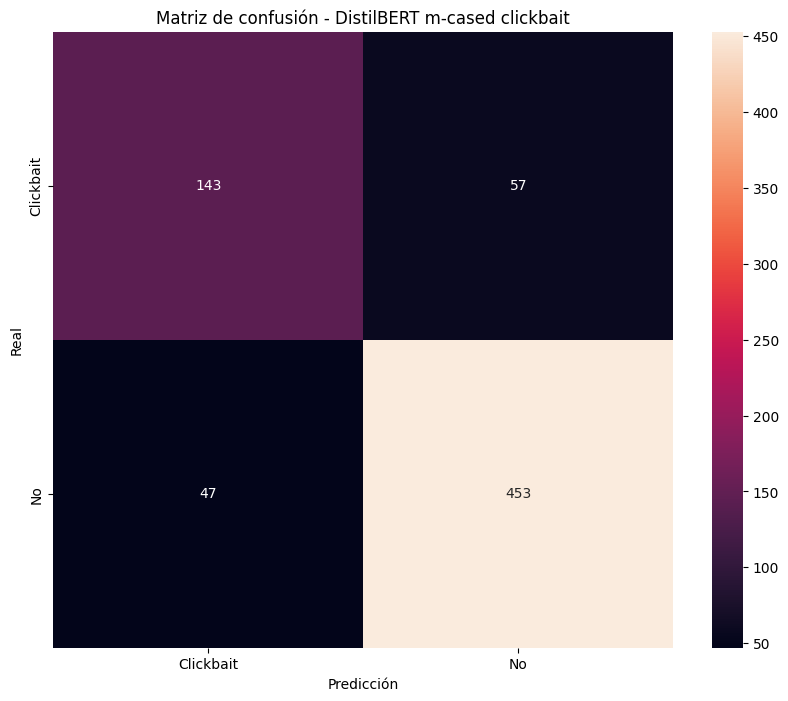


Reporte de clasificación DistilBERT m-cased:
              precision    recall  f1-score   support

   Clickbait       0.75      0.71      0.73       200
          No       0.89      0.91      0.90       500

    accuracy                           0.85       700
   macro avg       0.82      0.81      0.82       700
weighted avg       0.85      0.85      0.85       700



In [95]:
predictions = trainer.predict(eval_dataset)

y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=-1)

label_names = dataset["train"].features["labels"].names

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=label_names,
    yticklabels=label_names
)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión - DistilBERT m-cased clickbait")
plt.show()

print("\nReporte de clasificación DistilBERT m-cased:")
class_DistilBERT = classification_report(y_true, y_pred, target_names=label_names)
print(class_DistilBERT)

# Comparación de modelos

In [96]:
def get_metric(m, name):
    # Busca 'eval_name' o 'name' dentro del dict de métricas.
    return m.get(f"eval_{name}", m.get(name, None))

resultados = [
    {
        "Modelo": "DistilBERT-multilingüe",
        "Accuracy":      get_metric(metrics_DistilBERT, "accuracy"),
        "F1_macro":      get_metric(metrics_DistilBERT, "f1_macro"),
        "F1_weighted":   get_metric(metrics_DistilBERT, "f1_weighted"),
        "Loss":          get_metric(metrics_DistilBERT, "loss"),
    },
    {
        "Modelo": "XLM-R",
        "Accuracy":      get_metric(metrics_XLM, "accuracy"),
        "F1_macro":      get_metric(metrics_XLM, "f1_macro"),
        "F1_weighted":   get_metric(metrics_XLM, "f1_weighted"),
        "Loss":          get_metric(metrics_XLM, "loss"),
    },
    {
        "Modelo": "RoBERTa-es",
        "Accuracy":      get_metric(metrics_RoBERTa, "accuracy"),
        "F1_macro":      get_metric(metrics_RoBERTa, "f1_macro"),
        "F1_weighted":   get_metric(metrics_RoBERTa, "f1_weighted"),
        "Loss":          get_metric(metrics_RoBERTa, "loss"),
    },
    {
        "Modelo": "DistilBETO",
        "Accuracy":      get_metric(metrics_destil, "accuracy"),
        "F1_macro":      get_metric(metrics_destil, "f1_macro"),
        "F1_weighted":   get_metric(metrics_destil, "f1_weighted"),
        "Loss":          get_metric(metrics_destil, "loss"),
    },
    {
        "Modelo": "BETO",
        "Accuracy":      get_metric(metrics_BETO, "accuracy"),
        "F1_macro":      get_metric(metrics_BETO, "f1_macro"),
        "F1_weighted":   get_metric(metrics_BETO, "f1_weighted"),
        "Loss":          get_metric(metrics_BETO, "loss"),
    },
]

df_resultados = pd.DataFrame(resultados)

# Ordenar por F1_macro descendente
df_resultados = df_resultados.sort_values("F1_macro", ascending=False)

print(df_resultados.to_string(index=False))

                Modelo  Accuracy  F1_macro  F1_weighted     Loss
            RoBERTa-es  0.888571  0.857710     0.886110 0.685393
                 XLM-R  0.880000  0.850724     0.879056 0.642493
                  BETO  0.871429  0.839041     0.869985 0.804149
            DistilBETO  0.855714  0.822984     0.855606 0.651309
DistilBERT-multilingüe  0.851429  0.815182     0.850259 0.738061


# Generación del CSV detection.csv

Carga del dataset de prueba

In [98]:
test_df = pd.read_csv("TA1C_dataset_detection_test.csv")
print(test_df.head())

              Tweet ID  Tweet Date Media Name Media Origin  \
0  1303657772261703680  09-09-2020    El País      Uruguay   
1  1292878011839197188  10-08-2020    El País      Uruguay   
2  1287169218975281154  25-07-2020    El País      Uruguay   
3  1300152220214792192  30-08-2020    infobae    Argentina   
4  1298341509033418752  25-08-2020    infobae    Argentina   

                                         Teaser Text  
0  El mapa del desafuero de Manini Ríos: uno a un...  
1  #Peñarol  | Diego Forlán: "Queríamos ganar, pe...  
2  Benzema se ríe de los elogios del presidente d...  
3  “The Vow”: las sectas y las promesas de felici...  
4  Estados Unidos sancionó a un alto narcotrafica...  


Hacer el Dataset de HF

In [99]:
test_hf = Dataset.from_pandas(test_df[["Teaser Text"]])

def tokenize_test(examples):
    return tokenizer(
        examples["Teaser Text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH,
    )

test_encoded = test_hf.map(tokenize_test, batched=True)
test_encoded.set_format(type="torch", columns=["input_ids", "attention_mask"])

Map: 100%|██████████| 700/700 [00:00<00:00, 21676.31 examples/s]


Predicciones con el mejor modelo.

In [100]:
predicciones = trainer.predict(test_encoded)
pred_ids = np.argmax(predicciones.predictions, axis=-1)

label_names = dataset["train"].features["labels"].names
print("Label names:", label_names)

pred_tags = [label_names[i] for i in pred_ids]

Label names: ['Clickbait', 'No']


Contruir y guardar el dataset final

In [102]:
submission = pd.DataFrame({
    "Tweet ID": test_df["Tweet ID"],
    "Tag Value": pred_tags,
})

print(submission.head())

submission.to_csv("detection.csv", index=False)
print("Archivo detection.csv guardado con", len(submission), "filas")

              Tweet ID  Tag Value
0  1303657772261703680  Clickbait
1  1292878011839197188  Clickbait
2  1287169218975281154  Clickbait
3  1300152220214792192  Clickbait
4  1298341509033418752         No
Archivo detection.csv guardado con 700 filas
